# Discover SWOT L2_River product: multitemporal plot

![](https://img.shields.io/badge/CNES-tutorial-%20?color=blue&labelColor=grey)

_Authors: Damien Desroches, Mathilde Siméon (CNES)_
 
### Objectives
This tutorial explains  
* How to use riversp product for multitemporal analysis

### Requirements
1. Download SWOT products: 
   * RiverSP files 
2. Run the notebook in `swot-training` environment

### Content
* [Product overview](#The-River-product)
* [River product multitemporal heights](#River-product-multitemporal-heights)


## The River product

### Description
 
The RiverSP product is a vectorial product provided in shapefile format. It contains aggregated variables  from pixel cloud along :
- reaches (around 15 km river segment) 
- nodes (around 200m points along the river). 

<div>
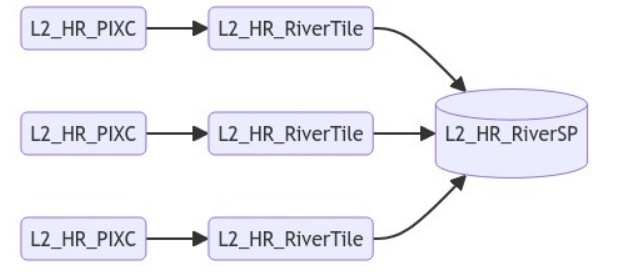
</div>

Only river defined in the SWORD river database are considered to compute this product. The nodes define a centerline that describe the river

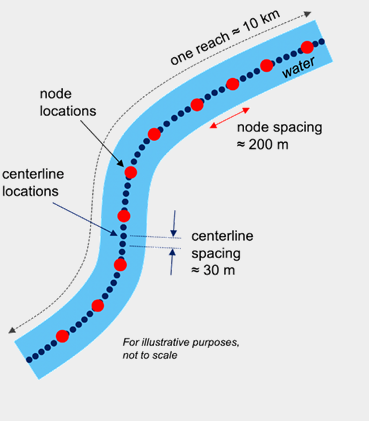
### When to use it ?

It can be useful for :
- Time monitoring of different rivers over a long period (wse, areas, etc...)
- Study of the characteristics of the river (wse, width, discharge, etc) and comparizon with other sensors

    
### Associated issues
 
- consulting the [ATBD/PDD](https://podaac.jpl.nasa.gov/SWOT?tab=datasets-information) documents to understand what are the different fields in the product and how there are computed
  

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from netCDF4 import Dataset
import xarray as xr 
from scipy.ndimage import uniform_filter
from shapely.geometry import Polygon
import geopandas as gpd
import shapefile
import pandas as pd
import requests
from PIL import Image
import io
from shapely.geometry import Point, LineString
import pyproj
from shapely.ops import nearest_points, transform
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
%matplotlib inline

## Make river products timeserie

In [2]:
output_path = "/work/EXPERT_CENTER/mwec/workspace/HR/tuto_ostst/data"

river_path_list = []

for root, dir, files in os.walk(output_path):
    for file in files:
        if file.endswith("shp") and file.split("_")[4] == 'Node':
            cycle_number = file.split("_")[5]
            river_path_list.append([os.path.join(root, file),os.path.join(root, '_'.join(file.split("_")[0:4])+"_Reach_"+'_'.join(file.split("_")[5:])), cycle_number])       
        
def takeSecond(elem):
    return elem[1]

river_path_list.sort(key=takeSecond)


### Select only some cycles

In [3]:
river_path_list = river_path_list[60:70]

# River product multitemporal heights

### Plot multitemporal heights profile (reaches height)

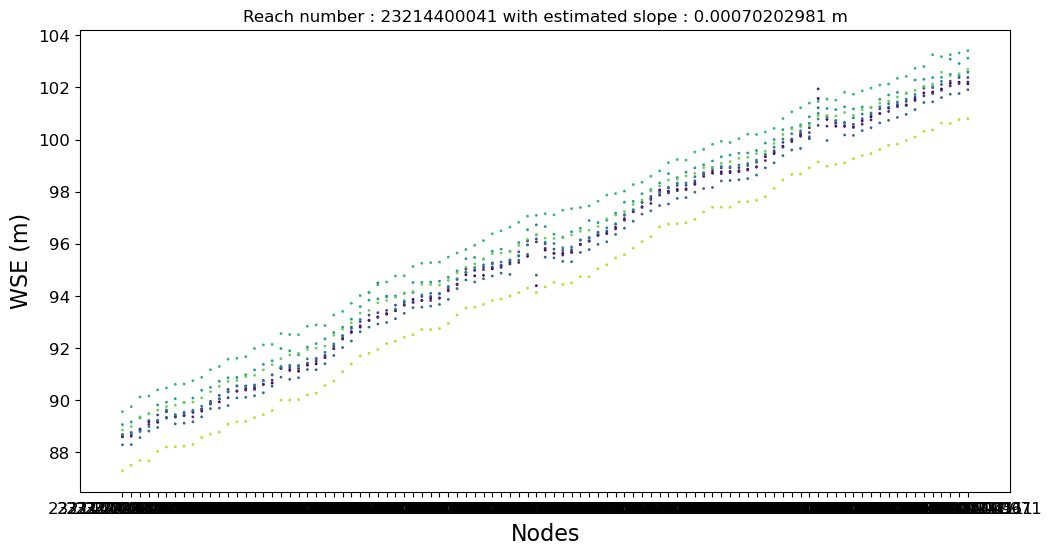

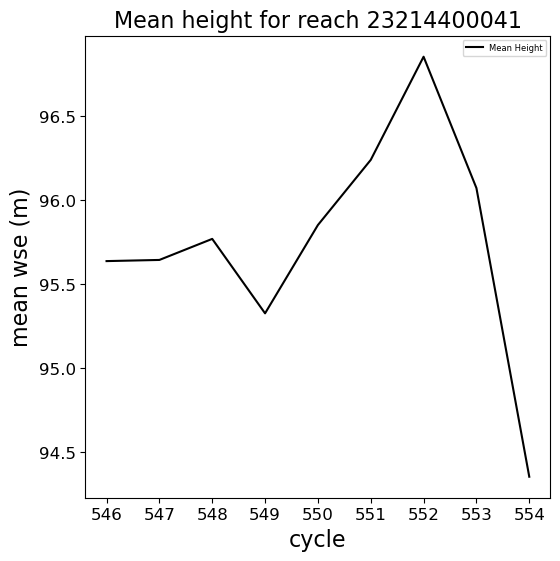

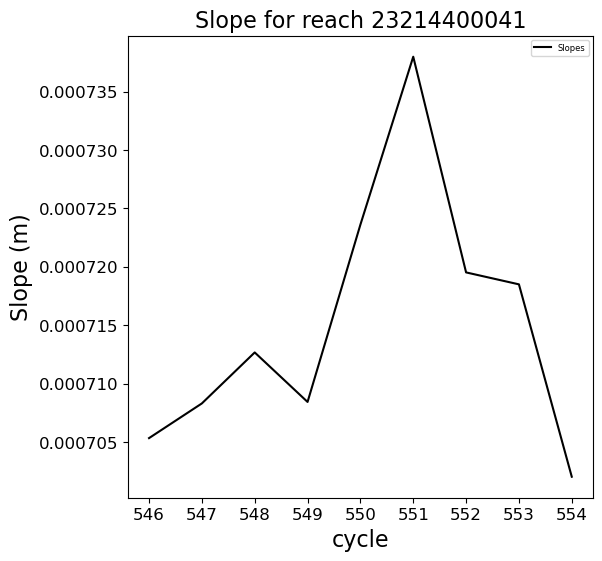

In [4]:
import warnings
warnings.filterwarnings('ignore')

reaches_list = ['23214400041']

for reach_processed in reaches_list:
    plt.figure(figsize=(12,6))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Water Surface Heights for reach number '+ reach_processed, fontsize=16)
    plt.xlabel('Nodes', fontsize=16)
    plt.ylabel('WSE (m)', fontsize=16)

    mean_height_cycle = []
    mean_height_weighted_cycle = []

    j=0
    cycles=[int(x[2]) for x in river_path_list]
    norm = colors.Normalize(vmin=np.min(cycles), vmax=np.max(cycles))
    for river_node_path, river_reach_path, cycle in river_path_list:
        j+=1
        ds_nodes = gpd.read_file(river_node_path)
        ds_reaches = gpd.read_file(river_reach_path)
        
        #ds_nodes = xr.open_dataset(river_path,group="nodes")
        #ds_reaches = xr.open_dataset(river_path,group="reaches")
        reaches = ds_reaches["reach_id"].values
        slopes = ds_reaches["slope"].values
        for k, i in enumerate(reaches):
            ind_nodes_i = np.where(ds_nodes["reach_id"].values == i)
            wse_i = ds_nodes["wse"].values[ind_nodes_i]
            nodes_i = ds_nodes["node_id"].values[ind_nodes_i]
            dark_frac_i = ds_nodes["dark_frac"].values[ind_nodes_i]
            wse_u_i = ds_nodes["wse_u"].values[ind_nodes_i]
            wse_r_u_i = ds_nodes["wse_r_u"].values[ind_nodes_i]
            ## select cycle superior to 471 (after HPA switch)
            if (np.isnan(np.nanmean(wse_i)) == False) & (np.abs(np.nanmean(wse_i)) < 9999.) & (str(i) == reach_processed) & (int(cycle) > 471):
                plt.title('Reach number : '+ str(i)+' with estimated slope : ' + str(slopes[k]) + ' m')
                #plt.scatter(nodes_i, wse_i, label='cycle ' + str(cycle)+ ', mean height = ' + str(round(np.nanmean(wse_i), 2)) + ' m' + ', slope = ' + str(round(slopes[k], 6)) + ' m', s=1)
                plt.scatter(nodes_i, wse_i, label='cycle ' + str(cycle), s=1, c=int(cycle)*np.ones(len(nodes_i)), norm=norm, cmap='viridis') 
                mean_height_cycle.append([cycle, np.nanmean(wse_i), slopes[k]])
                #mean_height_weighted_cycle.append([cycle, np.nansum((1-dark_frac_i)*wse_i)/np.nansum(1-dark_frac_i)])
                #mean_height_weighted_cycle.append([cycle, np.nansum(1/wse_r_u_i*wse_i)/np.nansum(1/wse_r_u_i)])
                mean_height_weighted_cycle.append([cycle, np.nansum(1/wse_u_i*wse_i)/np.nansum(1/wse_u_i)])
    #plt.legend(loc='lower right', labelspacing=0.2, fontsize=6)
    #plt.colorbar(label='cycle')

    mean_height_cycle = np.array(mean_height_cycle, dtype=float)
    mean_height_weighted_cycle = np.array(mean_height_weighted_cycle, dtype=float)

    try:
        plt.figure(figsize=(6,6))
        plt.title('Mean height for reach '+ reach_processed, fontsize=16)
        plt.xlabel('cycle', fontsize=16)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylabel('mean wse (m)', fontsize=16)
        plt.plot(mean_height_cycle[:,0], mean_height_cycle[:,1], color='k', label='Mean Height')
        #plt.plot(mean_height_weighted_cycle[:,0], mean_height_weighted_cycle[:,1], color='blue', label='Mean Weighted Height')
        plt.legend(fontsize=6)
    
        plt.figure(figsize=(6,6))
        plt.title('Slope for reach '+ reach_processed, fontsize=16)
        plt.xlabel('cycle', fontsize=16)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylabel('Slope (m)', fontsize=16)
        plt.plot(mean_height_cycle[:,0], mean_height_cycle[:,2], color='k', label='Slopes')
        #plt.plot(mean_height_weighted_cycle[:,0], mean_height_weighted_cycle[:,1], color='blue', label='Mean Weighted Height')
        plt.legend(fontsize=6)
    
        
        
    except:
        pass
    

### Manipulate geopandas to plot heights along the river (nodes height)

In [5]:
def HQ_image(xmin, ymin, xmax, ymax):
    ResRef = 2048 / 3
    coor = {"llon": xmin, "llat": ymin, "ulon": xmax, "ulat": ymax}

    DeltaX = float(xmax - xmin)
    DeltaY = float(ymax - ymin)
    ratio_lat_over_lon = DeltaY / DeltaX
    if DeltaX > DeltaY:
        ResX = ResRef
        ResY = int(ResRef * ratio_lat_over_lon)
    elif DeltaX < DeltaY:
        ResX = int(ResRef / ratio_lat_over_lon)
        ResY = ResRef
    else:
        ResX = ResRef
        ResY = ResRef

    # You can check for more server here: https://server.arcgisonline.com/arcgis/rest/services
    server = (
        "https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer"
    )

    basemap_url = (
        server
        + "/export?bbox={}E7%2C{}E7%2C{}E7%2C{}E7%2C&size={},{}&dpi={}&format={}&f=image".format(
            xmin, ymin, xmax, ymax, ResX, ResY, 200, "png32"
        )
    )

    resp = requests.get(basemap_url)
    print(basemap_url)

    im = Image.open(io.BytesIO(resp.content))

    return im

In [6]:
gdf_river = None
for river_node_path, river_reach_path, cycle in river_path_list:
    if cycle == '550':
        df_sw = gpd.read_file(river_node_path)
        #df_sw = ds.to_dataframe()
        gdf_sw = gpd.GeoDataFrame(
    df_sw, geometry=gpd.points_from_xy(df_sw.lon, df_sw.lat), crs="EPSG:4326"
)


        #gdf_sw = gdf_sw[
        #    (gdf_sw["node_id"] == 2.321490e+13)
        #].reset_index(drop=True)

        if gdf_river is None:
            gdf_river = gdf_sw
        else:
            gdf_river = pd.concat([gdf_river, gdf_sw], ignore_index=True)
        
gdf_river = gdf_river[gdf_river["wse"] > 0].reset_index(drop=True)
gdf_river = gdf_river[gdf_river["node_q"] < 3].reset_index(drop=True)
gdf_river = gdf_river[np.abs(gdf_river["xtrk_dist"]) > 10000].reset_index(drop=True)


In [7]:
proj_km = "epsg:32638"
radius = 5000

[xmin, ymin, xmax, ymax] = (
    gdf_river.to_crs("EPSG:3857").buffer(radius).total_bounds * 1e-7
)
bounds = gdf_river.to_crs("EPSG:3857").buffer(radius).to_crs(gdf_river.crs).total_bounds

im = HQ_image(xmin, ymin, xmax, ymax)

ref_point_im = gpd.GeoDataFrame(
    index=[0], geometry=[Point(xmin * 1e7, ymin * 1e7)], crs="EPSG:3857"
)
ref_point_km = ref_point_im.to_crs(proj_km)

xref, yref = (
    ref_point_km.geometry.iloc[0].xy[0][0],
    ref_point_km.geometry.iloc[0].xy[1][0],
)

dx = 5000
length = 20000

x1, y1 = xref + dx, yref + dx / 3
x2, y2 = xref + length + dx, yref + dx

project = pyproj.Transformer.from_crs(
    pyproj.CRS(proj_km), pyproj.CRS("EPSG:4326"), always_xy=True
).transform
p1, p2 = Point(x1, y1), Point(x2, y1)
p1 = transform(project, p1)
p2 = transform(project, p2)

p2 = Point(p2.x, p1.y)
scale_km = LineString([p1, p2])

gdf_scale = gpd.GeoDataFrame(index=[0], geometry=[scale_km], crs="EPSG:4326")

https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/export?bbox=-0.053818296868282295E7%2C0.5052071932506185E7%2C0.024235072058690642E7%2C0.762572284696429E7%2C&size=207,682.6666666666666&dpi=200&format=png32&f=image


[-4.83457986 41.26880754  2.17707356 56.33662862]


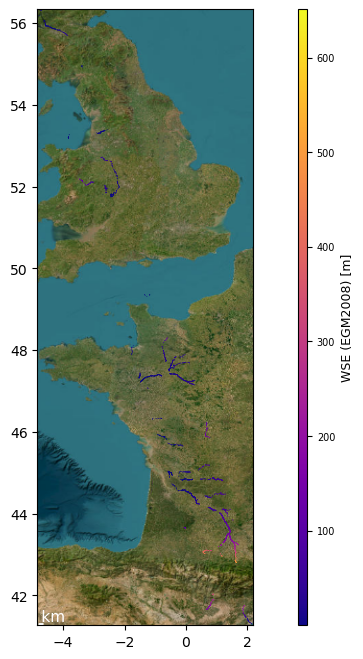

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.imshow(im, extent=[bounds[0], bounds[2], bounds[1], bounds[3]], aspect="equal")
print(bounds)
cb_im = ax.scatter(
    gdf_river.geometry.x,
    gdf_river.geometry.y,
    c=gdf_river["wse"],
    s=0.2,
    edgecolor="None",
    cmap="plasma",
    #vmin=0,
    #vmax=45,
    zorder=101,
)

ax.set_xlim((bounds[0], bounds[2]))
ax.set_ylim((bounds[1], bounds[3]))

gdf_scale.plot(ax=ax, color="white", lw=2)
x_scale = (
    gdf_scale.geometry.iloc[0].xy[0][0] + gdf_scale.geometry.iloc[0].xy[0][1]
) / 2
y_scale = gdf_scale.geometry.iloc[0].xy[1][0]
ax.text(
    x_scale,
    y_scale,
    "{} km".format(int(length * 1e-3)),
    color="w",
    fontsize=11,
    horizontalalignment="center",
    verticalalignment="bottom",
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
cb = plt.colorbar(cb_im, cax=cax)
cb.set_label(label="WSE (EGM2008) [m]", size=9)
cb.ax.tick_params(labelsize=7)